# Random walk simulation (MITx 15.455x)
This notebook is a Python translation of the R code from the provided edX notebook.

**Notes**
- Data source: Yahoo Finance via `yfinance`.
- Uses `Adjusted Close` for prices, and log-returns.

## 0. Setup

In [30]:
# If needed (run once):
# !pip -q install yfinance pandas numpy matplotlib scipy

import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (10, 4)

## 1. Download data (Tootsie Roll: TR)

In [31]:
ticker = "TR"
date_first = "1987-12-31"
date_last  = "2017-12-31"

if os.path.exists("./TR.csv"):
    TR = pd.read_csv("./TR.csv", parse_dates=["date"])
else:
    TR = yf.download(
        ticker,
        start=date_first,
        end=date_last,
        auto_adjust=False,  # keep Adj Close column
        progress=False,
    )

    if isinstance(TR.columns, pd.MultiIndex):
        TR.columns = TR.columns.droplevel(1)  # 丢掉第二层 (Ticker)
        TR.columns.name = None  # 去掉 "Price" 这个列名

    TR = TR.rename(
        columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Adj Close": "adjusted",
            "Volume": "volume",
        }
    )
    TR = TR.reset_index().rename(columns={"Date": "date"})

TR.head()

,symbol,date,open,high,low,close,volume,adjusted
0,TR,1987-12-31,4.083359,4.256382,4.083359,4.256382,25286,2.755930
1,TR,1988-01-04,4.256382,4.394801,4.221778,4.290987,40457,2.778338
2,TR,1988-01-05,4.360197,4.637034,4.360197,4.464011,114146,2.890368
3,TR,1988-01-06,4.533220,4.550523,4.360197,4.515918,60685,2.923977
4,TR,1988-01-07,4.498616,5.069594,4.498616,5.017687,103310,3.248863


## 2. Plot adjusted price

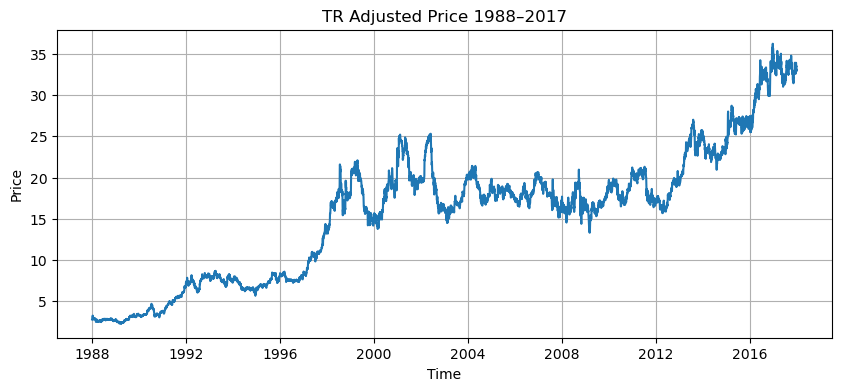

In [32]:
plt.figure()
plt.plot(TR["date"], TR["adjusted"])
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("TR Adjusted Price 1988–2017")
plt.grid(True)
plt.show()

## 3. Compute log returns and plot

In [ ]:
P = TR["adjusted"].to_numpy()
r = np.diff(np.log(P))
N = len(r)

TR["r"] = np.log(TR["adjusted"]).diff()
TR = TR.dropna(subset=["r"]).reset_index(drop=True)

plt.figure()
plt.plot(TR["date"], TR["r"])
plt.xlabel("Time")
plt.ylabel("Return")
plt.title("TR Daily Log Returns 1988–2017")
plt.grid(True)
plt.show()

,symbol,date,open,high,low,close,volume,adjusted,r
0,TR,1988-01-08,4.913872,4.913872,4.429406,4.429406,174832,2.867962,-0.124703
1,TR,1988-01-11,4.498616,4.671639,4.394801,4.394801,162550,2.845556,-0.007843
2,TR,1988-01-12,4.429406,4.464011,4.394801,4.429406,56351,2.867962,0.007843
3,TR,1988-01-13,4.394801,4.533220,4.394801,4.533220,30343,2.935179,0.023167
4,TR,1988-01-14,4.464011,4.515918,4.446708,4.464011,38290,2.890368,-0.015385


## 4. White noise with same volatility

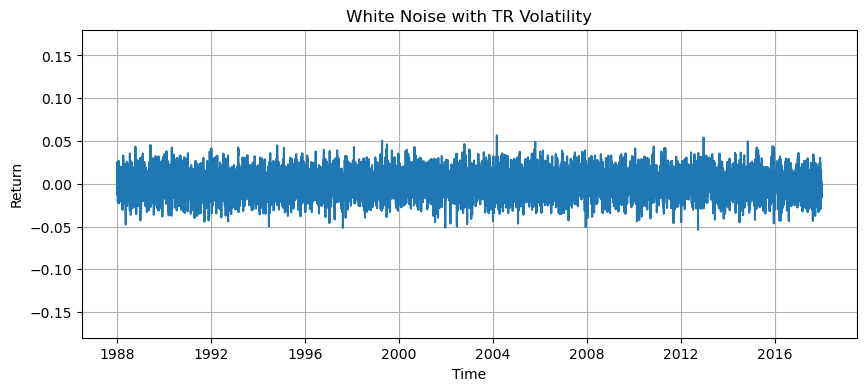

In [34]:
plt.figure()
plt.plot(TR["date"], np.random.randn(len(TR)) * TR["r"].std(ddof=1))
plt.ylim(-0.18, 0.18)
plt.xlabel("Time")
plt.ylabel("Return")
plt.title("White Noise with TR Volatility")
plt.grid(True)
plt.show()

## 5. Summary stats and histogram

          adjusted            r
count  7557.000000  7557.000000
mean     15.745320     0.000307
std       7.981683     0.015209
min       2.262289    -0.152747
25%       7.793378    -0.007803
50%      17.129675     0.000000
75%      19.953978     0.008089
max      36.243126     0.172633

Annualized mean return: 0.0773258369513423
Annualized volatility: 0.24144152745797184



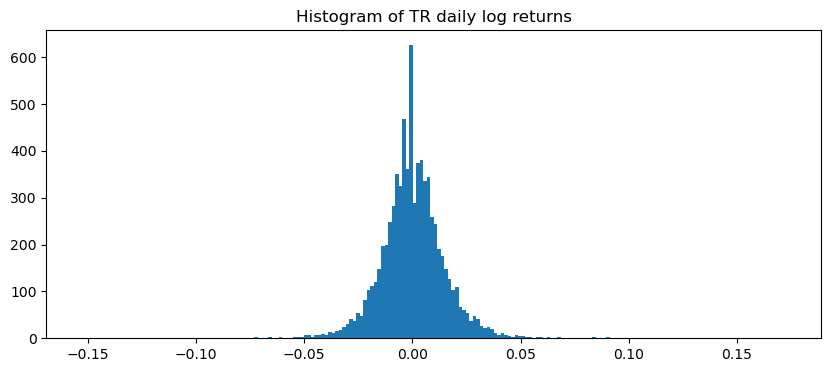

In [53]:
print(TR[["adjusted", "r"]].describe())
print()
print("Annualized mean return:", r.mean() * 252)
print("Annualized volatility:", r.std(ddof=1) * np.sqrt(252))
print()

plt.figure()
plt.hist(r, bins=200)
plt.title("Histogram of TR daily log returns")
plt.show()

## 6. Variance of returns from n-day observations (Lo–MacKinlay style)

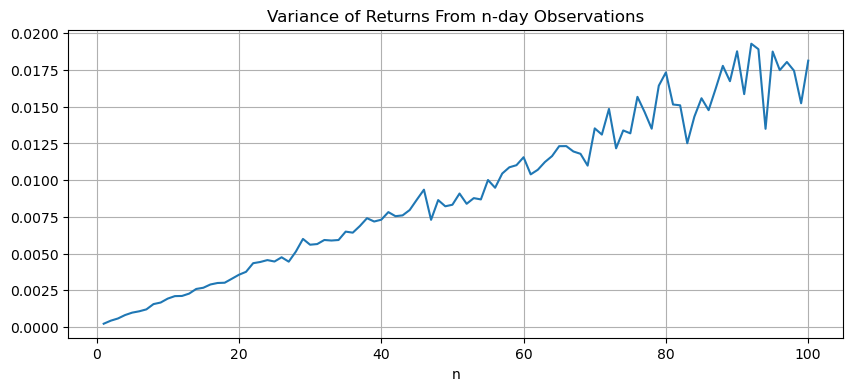

In [54]:
Variance = np.zeros(101)
Variance[1] = np.var(np.diff(np.log(P)), ddof=1)

for n in range(2, 101):
    idx = np.arange(n-1, len(P), n)   # sample every n-th observation, aligned to R's seq(from=n,...)
    Pn = P[idx]
    Variance[n] = np.var(np.diff(np.log(Pn)), ddof=1)

plt.figure()
plt.plot(range(1, 101), Variance[1:])
plt.xlabel("n")
plt.title("Variance of Returns From n-day Observations")
plt.grid(True)
plt.show()

## 7. Variance ratio test (overlapping) — z-stats and p-values

In [56]:
def variance_c(X: np.ndarray, q: int) -> float:
    """Overlapping q-period variance statistic (Lo & MacKinlay 1988 style)."""
    T = len(X) - 1
    mu = (X[T] - X[0]) / T
    m = (T - q) * (T - q + 1) * q / T
    sumsq = 0.0
    for t in range(q, T + 1):
        sumsq += (X[t] - X[t - q] - q * mu) ** 2
    return sumsq / m

def z_stat(X: np.ndarray, q: int) -> float:
    """Asymptotic z-statistic for variance ratio test."""
    T = len(X) - 1
    c = np.sqrt(T * (3 * q) / (2 * (2 * q - 1) * (q - 1)))
    M = variance_c(X, q) / variance_c(X, 1) - 1
    return c * M

logP = np.log(P)

Vc = np.zeros(101)
for q in range(1, 101):
    Vc[q] = variance_c(logP, q)

zstats = np.zeros(101)
for q in range(2, 101):
    zstats[q] = z_stat(logP, q)

pValues = 2 * norm.sf(np.abs(zstats))  # two-sided p-values

# Quick peek
pd.DataFrame({"q": range(2, 101), "z": zstats[2:], "p": pValues[2:]}).head()

,q,z,p
0,2,-6.000686,1.964859e-09
1,3,-7.400616,1.355539e-13
2,4,-7.025673,2.130371e-12
3,5,-6.722875,1.781740e-11
4,6,-6.733189,1.659843e-11


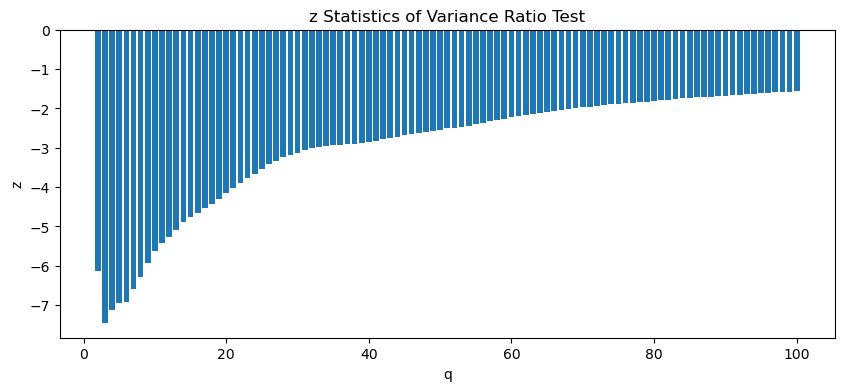

In [38]:
plt.figure()
plt.bar(range(2, 101), zstats[2:])
plt.xlabel("q")
plt.ylabel("z")
plt.title("z Statistics of Variance Ratio Test")
plt.show()

z stat显著小于0且大部分小于-2，等价$VR(n) = \frac{\mathrm{Var}(R^{(n)})}{n\,\mathrm{Var}(R^{(1)})} \;<\; 1$，收益存在负自相关（mean reversion）。

## 8. Volatility scaling from n-day observations

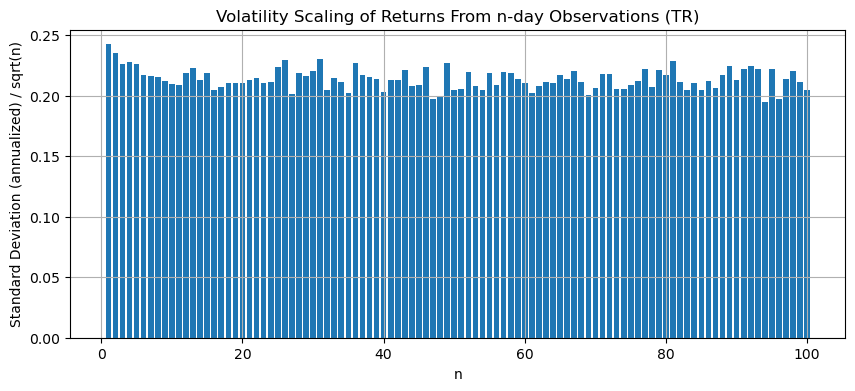

In [39]:
sigma = np.zeros(101)
sigma[1] = np.sqrt(252) * np.std(np.diff(np.log(P)), ddof=1)

for n in range(2, 101):
    idx = np.arange(n-1, len(P), n)
    Pn = P[idx]
    sigma[n] = np.sqrt(252 / n) * np.std(np.diff(np.log(Pn)), ddof=1)

plt.figure()
plt.bar(range(1, 101), sigma[1:])
plt.xlabel("n")
plt.ylabel("Standard Deviation (annualized) / sqrt(n)")
plt.title("Volatility Scaling of Returns From n-day Observations (TR)")
plt.grid(True)
plt.show()

## 9. Monte Carlo comparison (simulated lognormal price path)

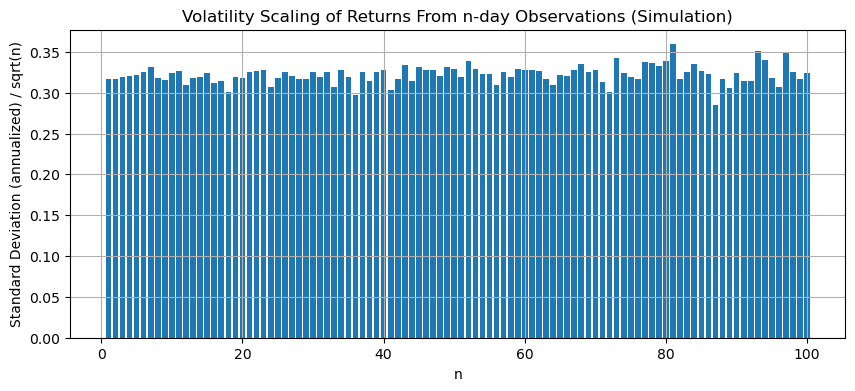

In [40]:
P_MC = np.exp(np.cumsum(np.random.randn(N) * 0.02))  # 0.02 is daily log-return std in the R notebook
sigma_MC = np.zeros(101)
sigma_MC[1] = np.sqrt(252) * np.std(np.diff(np.log(P_MC)), ddof=1)

for n in range(2, 101):
    idx = np.arange(n-1, len(P_MC), n)
    Pn = P_MC[idx]
    sigma_MC[n] = np.sqrt(252 / n) * np.std(np.diff(np.log(Pn)), ddof=1)

plt.figure()
plt.bar(range(1, 101), sigma_MC[1:])
plt.xlabel("n")
plt.ylabel("Standard Deviation (annualized) / sqrt(n)")
plt.title("Volatility Scaling of Returns From n-day Observations (Simulation)")
plt.grid(True)
plt.show()